In [1]:
from collections import Counter, namedtuple, defaultdict
from datetime import datetime
from random import randrange
from scipy.stats import ttest_ind, percentileofscore, wilcoxon
from tqdm import tqdm
from matplotlib import pyplot as plt

import bisect
import glob
import numpy as np
import pandas as pd
import pylunar
import random
import re
import seaborn as sns
import scipy
import statsmodels.formula.api as smf 

import utils

# pandas display formatting
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option("display.precision", 4)

In [2]:
SECONDS_IN_DAY = 86400

## Collect data
We look at Top 20 coins listed on CoinGecko on Aug. 12, 2022, not including stablecoins or wrapped tokens.

Explain how data was gathered

Note: up until Aug. 1

Note: Particularly long functions are in `./utils.py`

TODO: Explain that these are preliminary results

In [66]:
DF_MAIN = pd.concat([pd.read_csv(fname) for fname in glob.glob("./data/CoinGecko_*.csv")])

# remove where marketcap == 0
print('Removing {} rows where `market_caps` == 0'.format((DF_MAIN['market_caps'] == 0).sum()))
DF_MAIN = DF_MAIN[DF_MAIN['market_caps'] != 0]

# remove where total volume == 0
print('Removing {} rows where `total_volumes` == 0'.format((DF_MAIN['total_volumes'] == 0).sum()))
DF_MAIN = DF_MAIN[DF_MAIN['total_volumes'] != 0]

# get latest marketcaps and sort tickers by that,
# preseving unixtime sorting
custom_dict = {
    v: k
    for (k, v) in enumerate(
        DF_MAIN.groupby('ticker').last().sort_values('market_caps').index
    )
}
DF_MAIN = df.groupby('ticker').apply(
    lambda x: x.sort_values('unixtime')
).sort_index(
    key=lambda x: x.map(custom_dict)
).reset_index(drop=True)

DF_MAIN

Removing 443 rows where `market_caps` == 0
Removing 637 rows where `total_volumes` == 0


,unixtime,date,ticker,prices,market_caps,total_volumes
0,1602720000,2020-10-15 02:00:00,FIL|USD,61.038,"915,358,566.580","132,708,244.779"
1,1602806400,2020-10-16 02:00:00,FIL|USD,61.038,"915,358,566.580","132,708,244.779"
2,1602892800,2020-10-17 02:00:00,FIL|USD,44.776,"696,448,104.463","274,288,780.331"
3,1602979200,2020-10-18 02:00:00,FIL|USD,42.373,"685,643,708.431","98,808,556.860"
4,1603065600,2020-10-19 02:00:00,FIL|USD,32.711,"547,941,026.328","76,475,484.525"
...,...,...,...,...,...,...
47775,1658880000,2022-07-27 02:00:00,BTC|USD,"21,235.612","405,692,421,501.527","53,995,620,035.181"
47776,1658966400,2022-07-28 02:00:00,BTC|USD,"22,908.884","437,193,517,021.845","54,498,281,944.452"
47777,1659052800,2022-07-29 02:00:00,BTC|USD,"23,822.068","454,806,622,614.759","55,609,627,980.657"
47778,1659139200,2022-07-30 02:00:00,BTC|USD,"23,847.583","459,609,388,579.555","41,089,335,195.640"


### Summary Statistics

Note: We use monthly log return as one of the summary statistics (over the more common daily log return) since cryptocurrencies are highly volatile and mean daily (as well as weekly) log returns are approximately 0 for majority tokens.

In [90]:
def cumulative_return(x):
    return (x.iloc[-1] - x.iloc[0]) / x.iloc[0]

def mean_monthly_log_return(x):
    return np.mean(np.log(x.shift(-30)/x).iloc[:-30])

def std_monthly_log_return(x):
    return np.std(np.log(x.shift(-30)/x).iloc[:-30])

df = DF_MAIN.groupby("ticker").agg(
    start_date=('date', lambda x: x.values[0][:10]),
    no_obs=('date', lambda x: len(x)),
    cumulative_return=('prices', cumulative_return),
    mean_monthly_log_return=('prices', mean_monthly_log_return),
    std_monthly_log_return=('prices', std_monthly_log_return),
)
df.style.format(formatter={
    "cumulative_return": "{:,.0%}",
    "mean_monthly_log_return": "{:.3f}",
    "std_monthly_log_return": "{:.2f}"
})

,start_date,no_obs,cumulative_return,mean_monthly_log_return,std_monthly_log_return
ticker,,,,,
ADA|USD,2017-10-18,1748,"1,861%",0.051,0.51
ALGO|USD,2019-06-22,1136,-89%,-0.034,0.37
ATOM|USD,2019-03-16,1234,71%,0.022,0.36
AVAX|USD,2020-09-22,678,359%,0.074,0.56
BCH|USD,2017-08-02,1825,-81%,-0.022,0.41
BNB|USD,2017-09-16,1778,"267,835%",0.129,0.54
BTC|USD,2013-12-27,3138,"3,121%",0.031,0.23
CRO|USD,2019-03-17,1233,64%,0.018,0.36
DOGE|USD,2013-12-27,3137,"12,707%",0.047,0.47


### Add moon phase data

In [91]:
def get_moon_phase(df):

    mi = pylunar.MoonInfo((51, 30, 36), (0, 7, 5)) # London, UK

    ### Create `moon_phase` column

    def add_moon_phase(date_string):
        # example data string:
        # "2012-06-19 14:08:00"
        mi.update(tuple(map(int, re.split("-|\s+|:", date_string))))
        return mi.fractional_phase()

    df["moon_phase"] = df['date'].apply(add_moon_phase)

    # find local minima (new moons)
    new_moon_idxs = list(df.moon_phase[
        (df.moon_phase.shift(1) > df.moon_phase) &\
        (df.moon_phase.shift(-1) > df.moon_phase)
    ].index)
    # find local maxima (full moons)
    full_moon_idxs = list(df.moon_phase[
        (df.moon_phase.shift(1) < df.moon_phase) &\
        (df.moon_phase.shift(-1) < df.moon_phase)
    ].index)
    
    def moon_cycle(row):
        return bisect.bisect(new_moon_idxs, row.name)

    def day_after_new_moon(row):
        nearest_new_moon = new_moon_idxs[bisect.bisect(new_moon_idxs, row.name) - 1]
        result = row.name - nearest_new_moon
        if result >= 0:
            return result
        return 30 - (new_moon_idxs[0] - row.name)

    df['moon_cycle'] = df.apply(moon_cycle, axis=1)
    df['days_after_new_moon'] = df.apply(day_after_new_moon, axis=1)

    return df


DF_MAIN = DF_MAIN.groupby('ticker').apply(get_moon_phase).sort_values(['ticker', 'unixtime'])

DF_MAIN

,unixtime,date,ticker,prices,market_caps,total_volumes,moon_phase,moon_cycle,days_after_new_moon
35428,1508284800,2017-10-18 02:00:00,ADA|USD,0.027,"696,021,404.308","2,351,678.122",0.032,0,28
35429,1508371200,2017-10-19 02:00:00,ADA|USD,0.027,"695,622,018.256","2,815,155.970",0.007,0,29
35430,1508457600,2017-10-20 02:00:00,ADA|USD,0.030,"785,580,027.642","8,883,473.082",0.002,1,0
35431,1508544000,2017-10-21 02:00:00,ADA|USD,0.029,"741,202,123.880","5,308,856.917",0.018,1,1
35432,1508630400,2017-10-22 02:00:00,ADA|USD,0.028,"720,669,848.472","2,901,876.122",0.053,1,2
...,...,...,...,...,...,...,...,...,...
40310,1658880000,2022-07-27 02:00:00,XRP|USD,0.337,"16,280,339,620.383","28,749,929,057.470",0.026,106,28
40311,1658966400,2022-07-28 02:00:00,XRP|USD,0.360,"17,311,121,486.447","25,637,669,862.022",0.006,106,29
40312,1659052800,2022-07-29 02:00:00,XRP|USD,0.372,"17,993,565,318.244","15,143,779,787.628",0.003,107,0
40313,1659139200,2022-07-30 02:00:00,XRP|USD,0.370,"18,046,047,855.846","9,366,962,075.838",0.019,107,1


### Test for sinusoidal curve

In [92]:
def cumulative_return(row, df, days=15):
    #print(row)
    ts_start = row.unixtime
    ts_end = ts_start + days * SECONDS_IN_DAY
    if ts_end not in df.index:
        return np.nan
    row2 = df.loc[ts_end]
    #print(ts_start, ts_end, row.prices, row2.prices)
    return (row2.prices - row.prices) / row.prices

def mean_daily_log_return(row, df, days=15):
    ts_start = row.unixtime
    ts_end = ts_start + days * SECONDS_IN_DAY
    # get daily log returns in this period
    log_returns = []
    tss = list(range(ts_start, ts_end + SECONDS_IN_DAY, SECONDS_IN_DAY))
    for i in range(len(tss) - 1):
        #print(tss[i], tss[i + 1])
        if tss[i] not in df.index or tss[i + 1] not in df.index:
            return np.nan
        #print("HERE")
        log_returns.append(
            np.log(
                df.loc[tss[i + 1]].prices / df.loc[tss[i]].prices
            )
        )
    #print("HERE2", log_returns)
    return np.mean(log_returns)


In [93]:
tickers = DF_MAIN.ticker.unique()

# initialize DataFrame
DF_RESULT = pd.DataFrame([],
    index=pd.Index(tickers, name='Ticker:'),
    columns=pd.MultiIndex.from_product([
      ['15 Day', '30 Day'],
      ['Cumulative', 'Mean Daily Log'],
      ['coef', 't', 'P>|t|']
    ], names=['Window:', 'Return:', 'Metric:'])
)

In [94]:
for i,tkr in tqdm(enumerate(tickers), total=len(tickers)):
    #print(tkr)
    df = DF_MAIN[DF_MAIN.ticker == tkr]
    #print(DF_MAIN.ticker)
    df = df.reset_index(drop=True)
    
    #print(df)
    
    # remove rows where `days_after_new_moon` >= 29 since data is much sparser for these values
    df = df[df.days_after_new_moon <= 28]
    # cosine transform
    df["cos_trans"] = np.cos(2 * np.pi * df["days_after_new_moon"] / 29.53)
    
    regs = []
    for days in [15, 30]:
        for fn in [cumulative_return, mean_daily_log_return]:
            key = '{}_day_{}'.format(days, fn.__name__)
            df[key] = df.apply(
                lambda row: fn(row, df.set_index("unixtime"), days),
                axis=1
            )
            regs.append(smf.ols('Q("{}") ~ cos_trans'.format(key), data=df).fit())
            
    #print(regs[0].params, reg[0].tvalues, reg[0].pvalues)
    
    DF_RESULT.loc[tkr] = [
        x for reg in regs
        for x in [
            reg.params.cos_trans,
            reg.tvalues.cos_trans,
            reg.pvalues.cos_trans
        ]
    ]
    
DF_RESULT

100%|███████████████████████████████████████████| 30/30 [06:29<00:00, 13.00s/it]


Window:       15 Day                                              30 Day  \
Return:   Cumulative              Mean Daily Log              Cumulative   
Metric:         coef      t P>|t|           coef      t P>|t|       coef   
Ticker:                                                                    
ADA|USD        0.024  1.408 0.159          0.002  1.940 0.053      0.036   
ALGO|USD      -0.050 -4.088 0.000         -0.002 -1.933 0.054      0.012   
ATOM|USD      -0.042 -3.580 0.000         -0.002 -2.090 0.037     -0.002   
AVAX|USD      -0.086 -2.775 0.006         -0.004 -2.325 0.021      0.000   
BCH|USD       -0.030 -2.645 0.008         -0.001 -1.898 0.058      0.012   
BNB|USD        0.225  2.701 0.007          0.001  0.603 0.547      0.123   
BTC|USD       -0.001 -0.156 0.876          0.000  0.555 0.579      0.001   
CRO|USD        0.007  0.597 0.551         -0.001 -1.302 0.193      0.005   
DOGE|USD      -0.028 -1.720 0.086         -0.000 -0.549 0.583      0.019   
DOT|USD       -0.063 -4.073 0.000         -0.004 -3.454 0.001      0.010   
ETC|USD       -0.051 -4.663 0.000         -0.001 -2.227 0.026      0.022   
ETH|USD       -0.020 -2.261 0.024         -0.001 -1.623 0.105      0.012   
FIL|USD       -0.082 -4.077 0.000         -0.006 -4.549 0.000     -0.007   
FLOW|USD      -0.134 -6.483 0.000         -0.009 -6.620 0.000     -0.006   
FTT|USD       -0.042 -4.347 0.000         -0.003 -4.476 0.000      0.008   
LEO|USD        0.004  0.658 0.510          0.001  1.391 0.165      0.005   
LINK|USD      -0.013 -1.086 0.277          0.000  0.305 0.760      0.010   
LTC|USD       -0.004 -0.557 0.577          0.000  0.483 0.629      0.006   
MATIC|USD      0.029  1.042 0.297         -0.000 -0.058 0.954      0.060   
NEAR|USD      -0.073 -3.711 0.000         -0.003 -2.419 0.016      0.013   
OKB|USD       -0.014 -1.271 0.204         -0.001 -2.019 0.044      0.009   
SHIB|USD      -0.098 -2.378 0.018         -0.004 -1.970 0.050      0.051   
SOL|USD       -0.103 -5.200 0.000         -0.006 -4.760 0.000     -0.014   
STETH|USD     -0.127 -9.627 0.000         -0.007 -6.885 0.000     -0.007   
TRX|USD       -0.115 -2.787 0.005          0.000  0.016 0.987     -0.227   
UNI|USD       -0.088 -4.949 0.000         -0.006 -5.229 0.000     -0.018   
VET|USD       -0.011 -0.927 0.354         -0.002 -1.854 0.064      0.010   
XLM|USD        0.040  2.110 0.035          0.001  1.340 0.181     -0.017   
XMR|USD       -0.014 -1.478 0.140         -0.000 -0.365 0.715      0.007   
XRP|USD        0.017  1.231 0.218          0.001  1.759 0.079     -0.035   

Window:                                             
Return:                Mean Daily Log               
Metric:        t P>|t|           coef      t P>|t|  
Ticker:                                             
ADA|USD    0.700 0.484         -0.001 -1.647 0.100  
ALGO|USD   0.670 0.503         -0.001 -1.408 0.160  
ATOM|USD  -0.091 0.928         -0.001 -1.563 0.119  
AVAX|USD   0.003 0.998         -0.002 -1.329 0.185  
BCH|USD    0.685 0.493         -0.001 -0.730 0.466  
BNB|USD    1.244 0.214         -0.000 -0.110 0.912  
BTC|USD    0.152 0.879         -0.000 -0.248 0.804  
CRO|USD    0.244 0.807         -0.000 -0.150 0.881  
DOGE|USD   0.723 0.470         -0.000 -0.872 0.383  
DOT|USD    0.327 0.744         -0.000 -0.347 0.729  
ETC|USD    1.174 0.240         -0.000 -0.603 0.547  
ETH|USD    0.759 0.448          0.000  0.330 0.742  
FIL|USD   -0.187 0.851         -0.003 -1.998 0.047  
FLOW|USD  -0.174 0.862          0.001  0.674 0.501  
FTT|USD    0.473 0.636          0.000  0.255 0.799  
LEO|USD    0.665 0.506         -0.001 -1.744 0.082  
LINK|USD   0.479 0.632         -0.000 -0.546 0.585  
LTC|USD    0.513 0.608         -0.000 -0.649 0.517  
MATIC|USD  1.441 0.150          0.001  0.975 0.330  
NEAR|USD   0.359 0.720         -0.001 -0.578 0.564  
OKB|USD    0.553 0.580         -0.000 -0.749 0.454  
SHIB|USD   0.506 0.613         -0.001 -0.405 0.686  
SOL|USD   -0.347 0.728         -0.001

In [103]:
s = DF_RESULT.style

s.format(precision=4)

s.columns = pd.MultiIndex.from_product([
  ['15 Day (Moon Phase)', '30 Day'],
  ['Cumulative', 'Mean Daily Log'],
  ['coef', 't', 'P>|t|']
], names=['Window:', 'Return:', ''])

s.set_table_styles([
    {'selector': '.index_name', 'props': 'font-weight:normal; font-weight: bold;'},
    {'selector': 'th.col_heading', 'props': 'text-align: center;'},
    {'selector': 'th.col_heading.level0', 'props': 'font-size: 2em; border-bottom: 1px solid darkgrey;'},
    {'selector': 'th.col_heading.level1', 'props': 'font-size: 1.5em; border-bottom: 1px solid darkgrey;'},
    {'selector': 'th.col_heading.level2', 'props': 'border-bottom: 1px solid darkgrey;'},
    {'selector': 'td', 'props': 'text-align: center; font-weight: normal;'},
    {'selector': 'th:not(.index_name)', 'props': 'background-color: #0c0c0c; color: white;'}
])

s.set_table_styles({
    ('30 Day', 'Cumulative', 'coef'): [
        {'selector': 'th', 'props': 'border-left: 2px solid white'},
        {'selector': 'td', 'props': 'border-left: 2px solid black'}
    ],
    ('15 Day', 'Mean Daily Log', 'coef'): [
        {'selector': 'td', 'props': 'border-left: 1px solid black'}
    ],
    ('30 Day', 'Mean Daily Log', 'coef'): [
        {'selector': 'td', 'props': 'border-left: 1px solid black'}
    ]
}, overwrite=False, axis=0)

def highlight_pvalues(s):
    def _color(pvalue):
        if pvalue < 0.001:
            return "FCF947"
        if pvalue < 0.01:
            return "FDFA75"
        if pvalue < 0.05:
            return "FEFDBA"
        if pvalue < 0.1:
            return "FFFEE8"
        else:
            return ""
    props = []
    for x in ['15 Day', '30 Day']:
        for y in ['Cumulative', 'Mean Daily Log']:
            pvalue = s[x, y, 'P>|t|']
            props.extend(['background-color:#{}'.format(_color(pvalue))] * 3)
    return props

s.apply(highlight_pvalues, axis=1)

In [705]:
DF_RESULT.columns = pd.MultiIndex.from_product([
                      ['15 Day (Moon Phase)', '30 Day'],
                      ['Cumulative', 'Mean Daily Log'],
                      ['coef', 't', 'P>|t|']
                  ], names=['Window:', 'Return:', ''])

In [706]:
DF_RESULT

Window: 15 Day (Moon Phase)                                           \
Return:          Cumulative              Mean Daily Log                
                       coef      t P>|t|           coef      t P>|t|   
Ticker:                                                                
BTC                   0.002  0.450 0.653          0.000  0.984 0.325   
ETH                  -0.020 -2.270 0.023         -0.001 -1.623 0.105   
BNB                   0.225  2.701 0.007          0.001  0.603 0.547   
XRP                  -0.003 -0.202 0.840          0.001  1.345 0.179   
ADA                   0.024  1.408 0.159          0.002  1.940 0.053   
SOL                  -0.103 -5.200 0.000         -0.006 -4.760 0.000   
DOT                  -0.055 -3.433 0.001         -0.003 -2.894 0.004   
DOGE                 -0.027 -1.685 0.092         -0.000 -0.549 0.583   
AVAX                 -0.086 -2.775 0.006         -0.004 -2.325 0.021   
STETH                -0.129 -9.522 0.000         -0.007 -6.883 0.000   
SHIB                 -0.365 -0.453 0.651         -0.003 -0.652 0.515   
MATIC                 0.029  1.042 0.297         -0.000 -0.058 0.954   
TRX                  -0.115 -2.787 0.005          0.000  0.016 0.987   
ETC                  -0.052 -4.707 0.000         -0.001 -2.227 0.026   
OKB                  -0.015 -1.437 0.151         -0.001 -2.040 0.042   
NEAR                 -0.080 -4.244 0.000         -0.004 -2.883 0.004   
LEO                   0.002  0.443 0.658          0.001  1.391 0.165   
LTC                  -0.028 -2.502 0.012         -0.000 -0.527 0.599   
LINK                 -0.013 -1.086 0.277          0.000  0.305 0.760   
FTT                  -0.044 -4.517 0.000         -0.003 -4.258 0.000   

Window:     30 Day                                           
Return: Cumulative              Mean Daily Log               
              coef      t P>|t|           coef      t P>|t|  
Ticker:                                                      
BTC          0.005  0.546 0.585         -0.000 -0.759 0.448  
ETH          0.012  0.751 0.453          0.000  0.330 0.742  
BNB          0.123  1.244 0.214         -0.000 -0.110 0.912  
XRP         -0.010 -0.361 0.718         -0.001 -2.338 0.020  
ADA          0.036  0.700 0.484         -0.001 -1.647 0.100  
SOL         -0.014 -0.347 0.728         -0.001 -0.781 0.435  
DOT          0.016  0.560 0.576         -0.000 -0.347 0.729  
DOGE         0.019  0.697 0.486         -0.000 -0.872 0.383  
AVAX         0.000  0.003 0.998         -0.002 -1.329 0.185  
STETH       -0.008 -0.413 0.680         -0.001 -0.860 0.391  
SHIB        -0.014 -0.009 0.993         -0.003 -0.987 0.324  
MATIC        0.060  1.441 0.150          0.001  0.975 0.330  
TRX         -0.227 -1.502 0.133         -0.001 -1.337 0.182  
ETC          0.021  1.151 0.250         -0.000 -0.603 0.547  
OKB          0.005  0.333 0.739         -0.001 -1.040 0.299  
NEAR        -0.008 -0.232 0.817         -0.002 -1.170 0.243  
LEO          0.003  0.347 0.728         -0.001 -1.744 0.082  
LTC          0.034  1.439 0.150         -0.000 -0.665 0.506  
LINK         0.010  0.479 0.632         -0.000 -0.546 0.585  
FTT          0.002  0.106 0.916          0.000  0.149 0.881

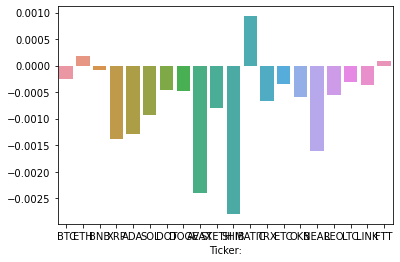

In [692]:
df = DF_RESULT[('30 Day', 'Mean Daily Log', 'coef')]

sns.barplot(x=df.index, y=df.values);

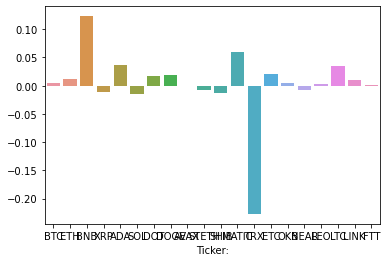

In [693]:
df = DF_RESULT[('30 Day', 'Cumulative', 'coef')]

sns.barplot(x=df.index, y=df.values);

In [ ]:
g = sns.FacetGrid(tips, row="window", col="return", margin_titles=True)
g.map(sns.barplot, "ticker", "total_bill", color=".3", fit_reg=False, x_jitter=.1)

In [733]:
coin_ids = [
        "bitcoin",
        "ethereum",
        "binancecoin",
        "ripple",
        "cardano",
        "solana",
        "polkadot",
        "dogecoin",
        "avalanche-2",
        "staked-ether",
        "shiba-inu",
        "matic-network",
        "tron",
        "ethereum-classic",
        "okb",
        "near",
        "leo-token",
        "litecoin",
        "chainlink",
        "ftx-token",
        "uniswap",
        "crypto-com-chain",
        "cosmos",
        "stellar",
        "monero",
        "flow",
        "bitcoin-cash",
        "algorand",
        "vechain",
        "filecoin"
    ]

In [734]:
len(set(coin_ids))

30